# Using Data Science for Bad Decision-Making

You will probably be intrigued by the title of this post. In this notebook Ido not want to present a fancy data science trick or to test a novel technique. I would simply like to tell a story. A story about how data science can be used to make bad decisions. "How can this be?" you might ask. Everyone has been saying that data is the way to unlock insights to gain a competitive advantage. Well, it is true. But it is also true that data can be used decisions that can actually hurt your business. There are many possible reasons you could think of (and you might even have experienced some of them). The story I am about to tell won't be about bad algorithms or bad data. It will be about thinking about data as simply

$$
\text{data in} \rightarrow \text{ML model} \rightarrow \text{data out} \rightarrow \text{decision}
$$

instead of thinking about the data generating process. In other words, it will be about not thinking about **causality**. 

### The Business Problem

The story begins in a fast paced startup. The company is growing fast and the marketing team is looking for ways to increase the sales from existing customers by making them buy more. The main idea is to unlock the potential of the customer based through incentives, in this case a discount. We of course want to measure the effect of the discount on the customer's behavior. Still, they do not want to waste money giving discounts to users which are not valuable. As always, it is about return on investment (ROI). Without going into specifics about the nature of the discount, it has been designed to provide a positive return on investment if the customer buys more than $1\$$ as a result of the discount. How can we measure the effect of the discount and make sure our experiment has a positive ROI? The marketing team came up with the following strategy:

- Select a sample of existing customers from the same cohort.
- Set a test window of 1 month.
- Look into the historical data of web visits from the last month. The hypothesis is that web visits are a good proxy for the customer's interest in the product.
- For customers with a high number of web visits, send them a discount. There will be a hold out group which will not receive the discount within the potential valuable customers based on the number of web visits. For customers with a low number of web visits, do not send them a discount (the marketing team wants to report a positive ROI, so they do not want to waste money on customers which are not valuable). Still, they want to use them to measure the effect of the discount.
- We also want to use the results of the test to cluster tag *loyal* customers. These are customers which got a discount (since they showed potential interest in the product) and customers with exceptional sales numbers even if they did not get a discount. The idea is to use this information to target them in the future if the discount strategy is positive.

### The Data

The team collected data from the experiment above and asked the data science team to analyze it and provide insights. In particular they want to know if they should keep the discount strategy. The data consists of the following fields:
- `visits`: Number of visits to the website during the test window.
- `discount`: Whether the customer received a discount or not.
- `is_loyal`: Whether the customer is loyal or not according to the definition above.
- `sales`: Sales in $\$$ during the test window.

### The Analysis

Now that the context, objectives and data are clear, let's look into the story about a relatively innocent analysis which turn out to be a pain and whose outcome and final decision was not the best one. But hey, do not worry, we will learn from it!

---

## Prepare Notebook

We want to make sure every component is reproducible so that the outcomes are not affected by pure randomness. We will set the random seed for the notebook and import the necessary libraries.

In [8]:
import arviz as az
import bambi as bmb
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [9]:
seed: int = sum(map(ord, "causality"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We read the data from a csv file.

In [22]:
data = pd.read_csv("../data/sales_dag.csv")

data.head()

,visits,discount,is_loyal,sales,sales_per_visit
0,12,0,0,13.348302,1.112359
1,26,1,1,21.701250,0.834663
2,13,0,0,14.700405,1.130800
3,24,0,0,20.377336,0.849056
4,14,0,0,12.633725,0.902409


In [23]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   visits           700 non-null    int64  
 1   discount         700 non-null    int64  
 2   is_loyal         700 non-null    int64  
 3   sales            700 non-null    float64
 4   sales_per_visit  700 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 27.5 KB


No missing values and features seem to be in the correct format.

## Exploratory Data Analysis

As part of the project scope, the data science team in charge of the analysis was asked to provide a summary of the data. The team was also asked to provide a visualization of the data to help the marketing team understand the data better. Data scientist A took over this task. They started by looking at the share oof customers which received a discount:

In [24]:
data["discount"].value_counts() / len(data)


discount
1    0.74
0    0.26
Name: count, dtype: float64

Similarly for the share of customers which are loyal:

In [25]:
data["is_loyal"].value_counts() / len(data)


is_loyal
1    0.75
0    0.25
Name: count, dtype: float64

To understand these features better, they also looked at a cross-tab table:

In [26]:
pd.crosstab(data["discount"], data["is_loyal"])


is_loyal,0,1
discount,,
0,175,7
1,0,518


Note that all customers with discount are loyal (as required) and that there are loyal users which did not receive a discount. This is because they had exceptional sales numbers. Let's verify this:

In [29]:
data.query("discount == 0").sort_values(by="sales", ascending=False).head(10)

,visits,discount,is_loyal,sales,sales_per_visit
566,33,0,1,31.721689,0.961263
204,33,0,1,28.311111,0.857912
365,33,0,1,28.081634,0.850959
49,33,0,1,27.790644,0.842141
280,29,0,1,27.581146,0.951074
545,27,0,1,26.255330,0.972420
104,29,0,1,26.217525,0.904053
361,28,0,0,24.094104,0.860504
651,28,0,0,24.064587,0.859450
493,27,0,0,24.006295,0.889122


The loyal customers are the top ones in terms of sales. This is good news. It means that the definition of loyal customers is consistent with the data.

In order to have orders of magnitude for the sales, the data scientist provided some summary statistics table:

In [31]:
data["sales"].describe()


count    700.000000
mean      19.400159
std        4.879144
min        2.088539
25%       16.443930
50%       19.495469
75%       22.500405
max       36.136312
Name: sales, dtype: float64

To have a better glimpse of the data, the data scientist also provided a histogram of the sales:

Text(0.5, 1.05, 'Sales Distribution')

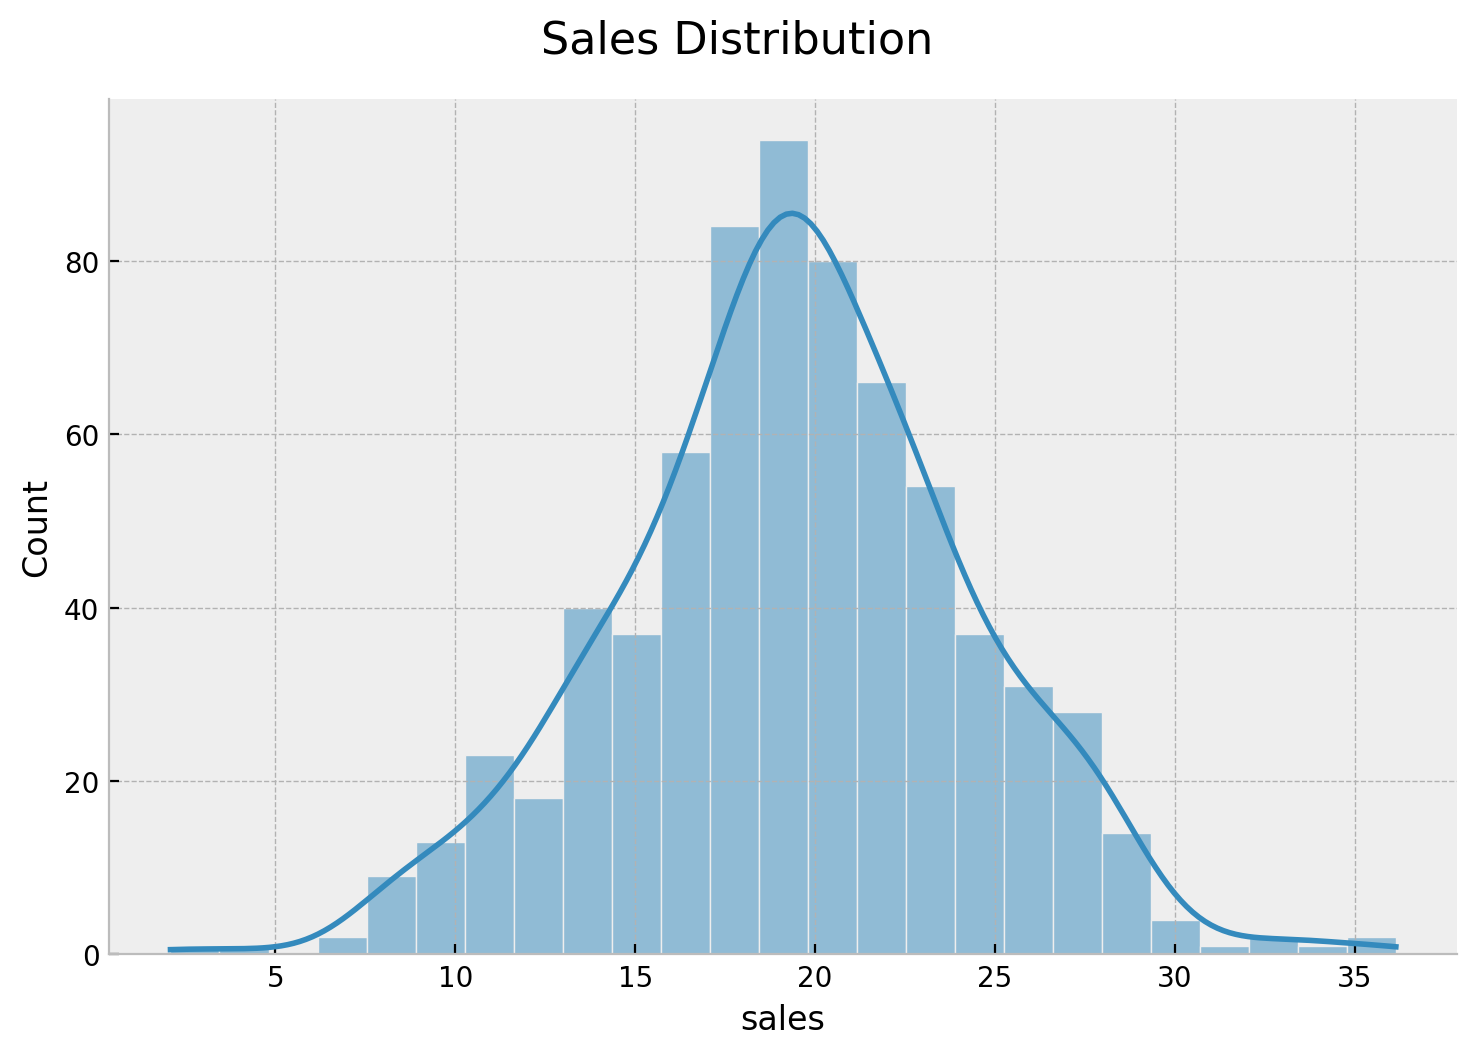

In [48]:
g = sns.displot(
    data=data, x="sales", kind="hist", kde=True, fill=True, height=5, aspect=1.5
)
g.fig.suptitle("Sales Distribution", y=1.05, fontsize=16)

## Descriptive Statistics

Data scientist A feels comfortable with the data and decides to move on to the discount analysis. The first thing they did was to split the sales distribution by discount group:

Text(0.5, 1.05, 'Sales Distribution by Discount Group')

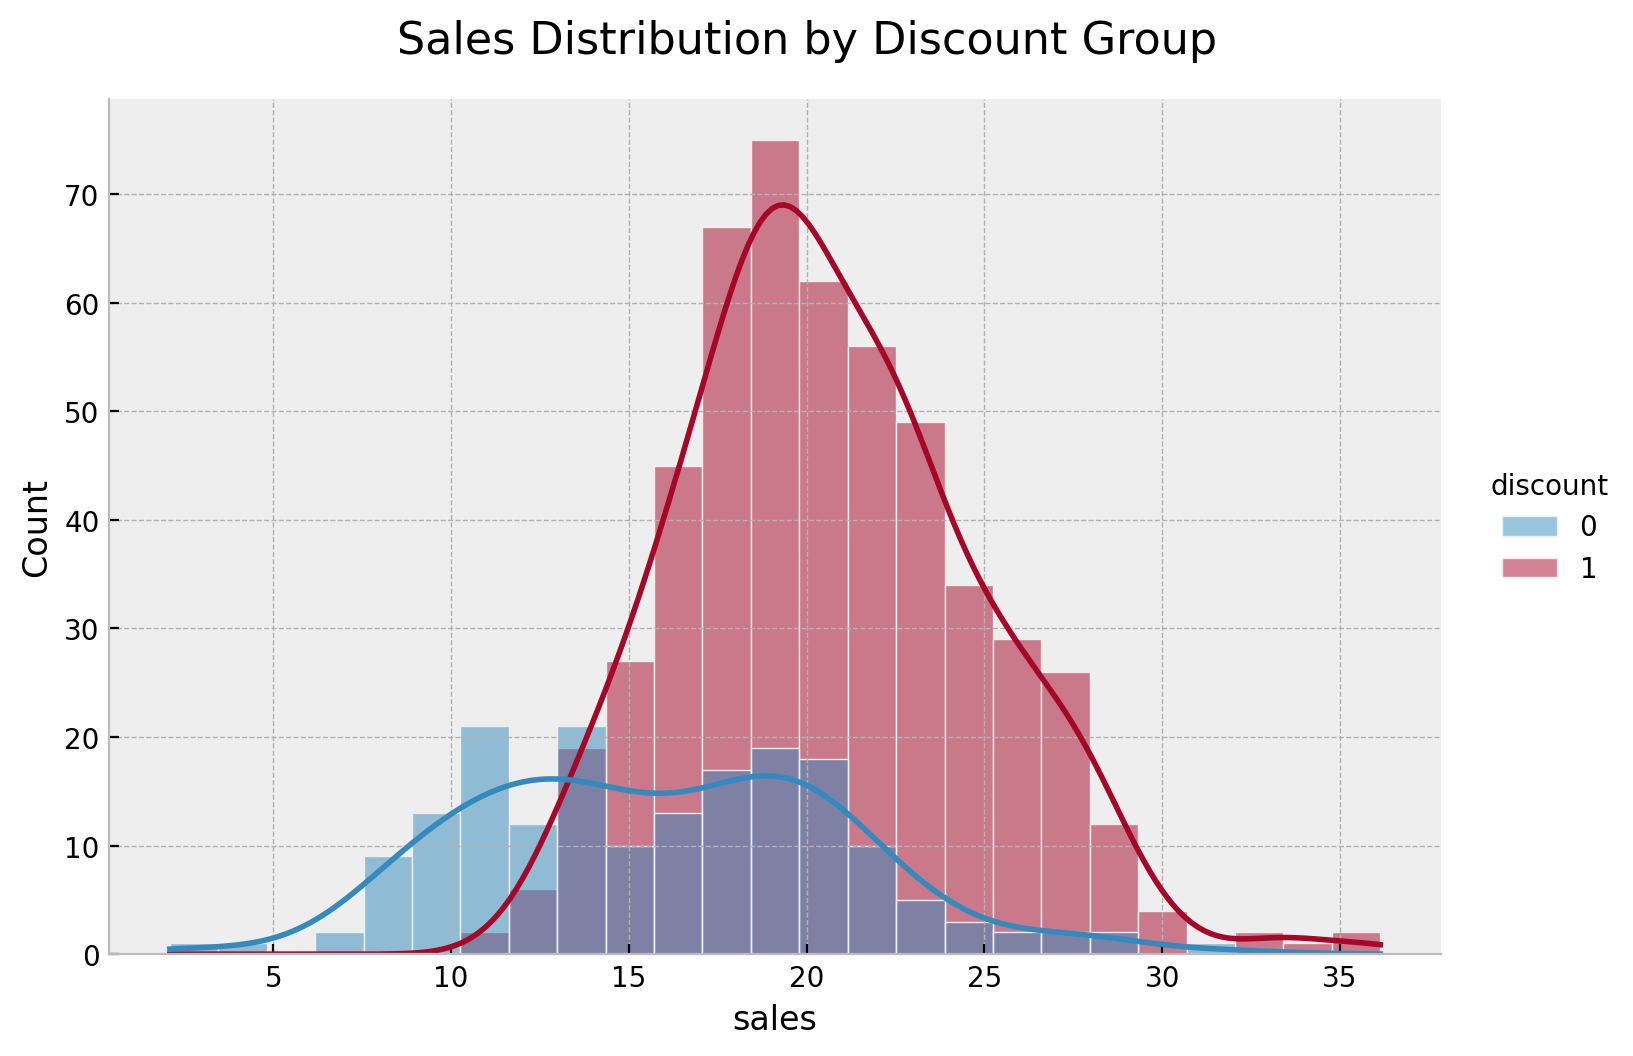

In [49]:
g = sns.displot(
    data=data,
    x="sales",
    kind="hist",
    hue="discount",
    kde=True,
    fill=True,
    height=5,
    aspect=1.5,
)
g.fig.suptitle("Sales Distribution by Discount Group", y=1.05, fontsize=16)


It looks customers with discount have higher sales. Data scientist A is optimistic with this initial result. To quantify this, they computed the difference in means:

In [50]:
data.groupby(["discount"]).agg({"sales": "mean"})

,sales
discount,
0,15.848788
1,20.647938


In [52]:
(
    data.query("discount == 1")["sales"].mean()
    - data.query("discount == 0")["sales"].mean()
)


4.799150094279289

Wow! We see $5\$$ mean uplift! This is great news. The discount strategy seems to be working. Data scientist A is happy with the results and decides to get feedback from the rest of the data science team.

In [ ]:
data.groupby(["discount"]).agg({"sales_per_visit": "mean"})

In [ ]:
sns.relplot(data=data, x="visits", y="sales", hue="is_loyal", col="discount")

In [ ]:
data.groupby(["is_loyal", "discount"]).agg({"sales": np.mean})

In [ ]:
g = sns.displot(
    data=data,
    x="sales",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales"].mean()
        ax.axvline(
            x=df.query(f"discount == {discount}")["sales"].mean(),
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle("Sales distribution by discount and loyalty", y=1.05, fontsize=16)

In [ ]:
g = sns.displot(data=data, x="sales_per_visit", hue="discount", kde=True, rug=True)

In [ ]:
g = sns.displot(
    data=data,
    x="sales_per_visit",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales_per_visit"].mean()
        ax.axvline(
            x=mean,
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle(
    "Sales per visit distribution by discount and loyalty", y=1.05, fontsize=16
)


In [ ]:
numeric_features = ["visits"]
categorical_features = ["discount", "is_loyal"]
features = numeric_features + categorical_features

X = data.assign(
    discount=lambda x: pd.Categorical(values=x["discount"], categories=[0, 1]),
    is_loyal=lambda x: pd.Categorical(values=x["is_loyal"], categories=[0, 1]),
).filter(items=features)

y = data["sales"].to_numpy()

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV


ml_model = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=seed),
    param_distributions=dict(
        learning_rate=uniform(loc=0.01, scale=0.1),
        n_estimators=randint(low=100, high=1_000),
        max_depth=randint(low=3, high=9),
    ),
    cv=8,
    n_iter=12,
    random_state=seed,
)

ml_model.fit(X=X, y=y)


y_pred = ml_model.predict(X=X)

fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(x=y, y=y_pred, color="C0", alpha=0.7, ax=ax)
ax.axline(xy1=(10, 10), slope=1, color="black", linestyle="--")
ax.set(
    title="ML Model - Actual vs Predicted Sales", xlabel="Actual", ylabel="Predicted"
)

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)

for b in [False, True]:
    PartialDependenceDisplay.from_estimator(
        estimator=ml_model,
        X=X,
        features=categorical_features,
        categorical_features=categorical_features,
        centered=b,
        random_state=seed,
        ax=ax[int(b)],
    )
fig.suptitle("ML Model - Partial Dependence Plots", y=1.05, fontsize=16)


In [ ]:
complete_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=10, sigma=3),
    "visits": bmb.Prior("Normal", mu=1, sigma=3),
    "discount": bmb.Prior("Normal", mu=0, sigma=3),
    "is_loyal": bmb.Prior("Normal", mu=0, sigma=3),
    "sigma": bmb.Prior("Exponential", lam=1 / 3),
}

complete_model = bmb.Model(
    formula="sales ~ discount + visits + is_loyal",
    data=data,
    family="gaussian",
    link="identity",
    priors=complete_model_priors,
)

complete_model

In [ ]:
complete_model.build()
complete_model.graph()


In [ ]:
complete_model_idata = complete_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)


In [ ]:
az.summary(data=complete_model_idata)


In [ ]:
axes = az.plot_trace(
    data=complete_model_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Complete Model - Trace", fontsize=16)


In [ ]:
fig, ax = plt.subplots()
az.plot_posterior(data=complete_model_idata, var_names=["discount"], ref_val=0, ax=ax)

In [ ]:
g = gr.Digraph()
g.node(name="sales", label="sales", color="deepskyblue", style="filled")
g.node(name="discount", label="discount", color="deeppink", style="filled")
g.edge(tail_name="discount", head_name="sales")
g.edge(tail_name="visits", head_name="discount")
g.edge(tail_name="visits", head_name="sales")
g.edge(tail_name="discount", head_name="is_loyal")
g.edge(tail_name="sales", head_name="is_loyal")
g


In [ ]:
causal_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=10, sigma=3),
    "visits": bmb.Prior("Normal", mu=1, sigma=3),
    "discount": bmb.Prior("Normal", mu=0, sigma=3),
    "sigma": bmb.Prior("Exponential", lam=1 / 3),
}

causal_model = bmb.Model(
    formula="sales ~ discount + visits",
    data=data,
    family="gaussian",
    link="identity",
    priors=causal_model_priors,
)

causal_model

In [ ]:
causal_model.build()
causal_model.graph()


In [ ]:
causal_model_idata = causal_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)


In [ ]:
az.summary(data=causal_model_idata)


In [ ]:
axes = az.plot_trace(
    data=causal_model_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Causal Model - Trace", fontsize=16)


In [ ]:
fig, ax = plt.subplots()
az.plot_posterior(data=causal_model_idata, var_names=["discount"], ref_val=0, ax=ax)

In [ ]:
fig, ax = plt.subplots()


az.plot_forest(
    data=[complete_model_idata, causal_model_idata],
    var_names=["discount"],
    model_names=["complete model", "causal model"],
    combined=True,
    ax=ax,
)


In [ ]:
X_causal = X.drop(columns=["is_loyal"])

ml_model.fit(X=X_causal, y=y)

fig, ax = plt.subplots()

PartialDependenceDisplay.from_estimator(
    estimator=ml_model,
    X=X_causal,
    features=["discount"],
    categorical_features=["discount"],
    centered=True,
    random_state=seed,
    ax=ax,
)
ax.set(title="ML Model (Causal) - Partial Dependence Plot (Centered)")
